In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import os
import re

import json
import addict
import numpy as np
import pandas as pd
import igraph as ig
import scanpy as sc
import scanpy.external as sce
from scipy.sparse import csr_matrix, isspmatrix

from datetime import datetime
time_start = datetime.now()

sc.logging.print_header()
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80)

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.24.4 scipy==1.11.1 pandas==2.0.3 scikit-learn==1.3.0 statsmodels==0.14.0 python-igraph==0.10.4 pynndescent==0.5.10


In [4]:
import sys
sys.path.append('..')

from src.configs import config
from src.utils import utils as us
from src.utils import visualise as vs
%load_ext autoreload
%autoreload 2
warnings.filterwarnings("once")

## 1.3 Custom Plotting Functions

In [5]:
os.makedirs(config.PATHS.LOGS, exist_ok=True)
os.makedirs(config.PATHS.LOGS/'appendix', exist_ok=True)
state = addict.Dict({ 'PROTOCOL': config.PROTO })
state.PROTO = config.PROTO.copy()

us.erase_log()
us.log(json.encoder.JSONEncoder(indent='  ').encode(state.PROTO))

{
  "SEED": 42,
  "EXPERIMENT_ID": "SUBSET_1",
  "DESCRIPTION": "WO OPEN Dataset, WO BANOBO",
  "DATASETS": {
    "E-MATB": true,
    "MENDELEY": false,
    "OPEN": false,
    "BATCH_FROM_TIMEPOINT": false
  },
  "SUBSET": {
    "APE_HUMAN_OVERLAP": true,
    "BANOBO": false,
    "TIMEPOINTS": [
      14,
      28,
      35,
      119,
      126
    ]
  },
  "PSEUDO_BULK": {
    "TYPE": "decoupler",
    "SIZE": 75,
    "REPS": 2
  },
  "CONTRAST": "",
  "QC": {
    "MIN_GENES": 500,
    "MAX_GENES": 5000,
    "MIN_COUNTS": 750,
    "MAX_COUNTS": 10000,
    "MT_PERCENTAGE": 5,
    "RB_PERCENTAGE": 35,
    "MIN_CELLS_PCT": 0.5
  }
}


In [6]:
datasets = list()
if config.PROTO.DATASETS['E-MATB']:
    datasets.append(sc.read(config.PATHS.CSV/'EMATB.h5ad'))
if config.PROTO.DATASETS['MENDELEY']:
    datasets.append(sc.read(config.PATHS.CSV/'MENDELEY.h5ad'))
if config.PROTO.DATASETS['OPEN']:
    datasets.append(sc.read(config.PATHS.CSV/'OPEN.h5ad'))

In [7]:
adata = us.merge_datasets(datasets)
adata.obs.head()

,timepoint,line,10X_date,clusters,tSNE_1,tSNE_2,cluster,timepoint_mapped,dataset
AAACCTGAGACCTAGG-4.d5_409b2_171212,d5,409b2,171212,C8,-89.187002,19.220198,C8,5,EMATB
AAACCTGAGTCCGTAT-4.d5_409b2_171212,d5,409b2,171212,C5,48.413219,-12.483613,C5,5,EMATB
AAACCTGGTATCTGCA-4.d5_409b2_171212,d5,409b2,171212,C5,86.033093,-7.297135,C5,5,EMATB
AAACCTGTCATAAAGG-4.d5_409b2_171212,d5,409b2,171212,C8,-99.750682,15.862280,C8,5,EMATB
AAACCTGTCGTTGCCT-4.d5_409b2_171212,d5,409b2,171212,C7,34.884410,62.724772,C7,5,EMATB


In [8]:
if config.PROTO.DATASETS.EMATB and config.PROTO.DATASETS.MENDELEY:
    atmp = adata[adata.obs.dataset == 'EMATB']
    btmp = adata[adata.obs.dataset != 'EMATB']
    a = { '-'.join(re.split(r'-|\.', el)[:2]) for el in atmp.obs.index }
    b = { '-'.join(re.split(r'-|\.', el)[:2]) for el in btmp.obs.index }
    atmp.obs.index = pd.Index([
        '-'.join(re.split(r'-|\.', el)[:2])
        for el in atmp.obs.index ])

    bidxs = pd.Index(b.difference(a))
    print(btmp.obs.loc[bidxs].timepoint.value_counts())

    btmp = btmp[pd.Index(b.difference(a))]
    adata = sc.concat([atmp, btmp])

### Whether to drop Bonobo & subset timepoints

In [9]:
if not config.PROTO.SUBSET.BONOBO:
    adata = adata[
        adata.obs.line.apply(lambda x: x.lower() not in config.BONOBO)]

adata = adata[
    adata.obs.timepoint_mapped.apply(
        lambda x: int(x) in config.PROTO.SUBSET.TIMEPOINTS)]

### Consider only overlap of Ape & Human genes

In [10]:
adata.obs['isHuman'] = adata.obs.line.apply(
    lambda x: x.lower() in config.HUMANS)

nonzero = adata.X[adata.obs['isHuman']].sum(0)
human_genes = adata.var[np.array(nonzero.tolist()[0]) != 0]

nonzero = adata.X[~adata.obs['isHuman']].sum(0)
ape_genes = adata.var[np.array(nonzero.tolist()[0]) != 0]

symdiff = ape_genes.index.symmetric_difference(human_genes.index).shape[0]
intersect = ape_genes.index.intersection(human_genes.index)

state['human_vs_apes_overlap'] = 1 - symdiff / (
    intersect.shape[0] + symdiff)
us.log(
    'The {:2.0f}% genes are overlaped bw Ape & Human in the data'.format(
        state['human_vs_apes_overlap'] * 100))

if config.PROTO.SUBSET.APE_HUMAN_OVERLAP:
    adata = adata[:, intersect]

/tmp/ipykernel_517918/1062825657.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['isHuman'] = adata.obs.line.apply(


The 78% genes are overlaped bw Ape & Human in the data


In [11]:
adata.obs['isESC'] = adata.obs.line.apply(
    lambda x: x.lower() in config.ESC)

nonzero = adata.X[(~adata.obs['isESC']) & adata.obs['isHuman']].sum(0)
induced_genes = adata.var[np.array(nonzero.tolist()[0]) != 0]

nonzero = adata.X[adata.obs['isESC']].sum(0)
ESC_genes = adata.var[np.array(nonzero.tolist()[0]) != 0]

symdiff = ESC_genes.index.symmetric_difference(
    induced_genes.index)
intersect = ESC_genes.index.intersection(induced_genes.index)

state['induced_vs_ESC_overlap'] = 1 - symdiff.shape[0] / (
    intersect.shape[0] + symdiff.shape[0])
us.log(
    'The {:2.0f}% genes are overlaped bw ESCs & Induced in the data'.format(
        state['induced_vs_ESC_overlap'] * 100))

if config.PROTO.SUBSET.APE_HUMAN_OVERLAP:
    adata = adata[:, intersect]

/tmp/ipykernel_517918/1268173437.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['isESC'] = adata.obs.line.apply(


The 98% genes are overlaped bw ESCs & Induced in the data


In [12]:
symdiff

Index(['ABCB5', 'AC004490.1', 'AC004837.5', 'AC005220.3', 'AC005477.1',
       'AC005481.5', 'AC005932.1', 'AC007906.1', 'AC010746.3', 'AC024592.12',
       ...
       'Z83844.1', 'ZC3H12D', 'ZC3HAV1L', 'ZFP3', 'ZFY', 'ZNF619', 'ZNF732',
       'ZNF835', 'ZSWIM2', 'bP-21264C1.2'],
      dtype='object', name='Unnamed: 0', length=390)

In [13]:
us.log(adata.shape)
us.log('isspmatrix: {}'.format(isspmatrix(adata.X)))


us.log('Loaded Filtered AnnData object: number of cells {}'.format(adata.n_obs))
us.log('Loaded Filtered AnnData object: number of genes {}'.format(adata.n_vars) )
us.log('Available metadata for each cell:  {}'.format(adata.obs.columns))

(31314, 17829)
isspmatrix: True
Loaded Filtered AnnData object: number of cells 31314
Loaded Filtered AnnData object: number of genes 17829
Available metadata for each cell:  Index(['timepoint', 'line', '10X_date', 'clusters', 'tSNE_1', 'tSNE_2',
       'cluster', 'timepoint_mapped', 'dataset', 'isHuman', 'isESC'],
      dtype='object')


# Cell metadata

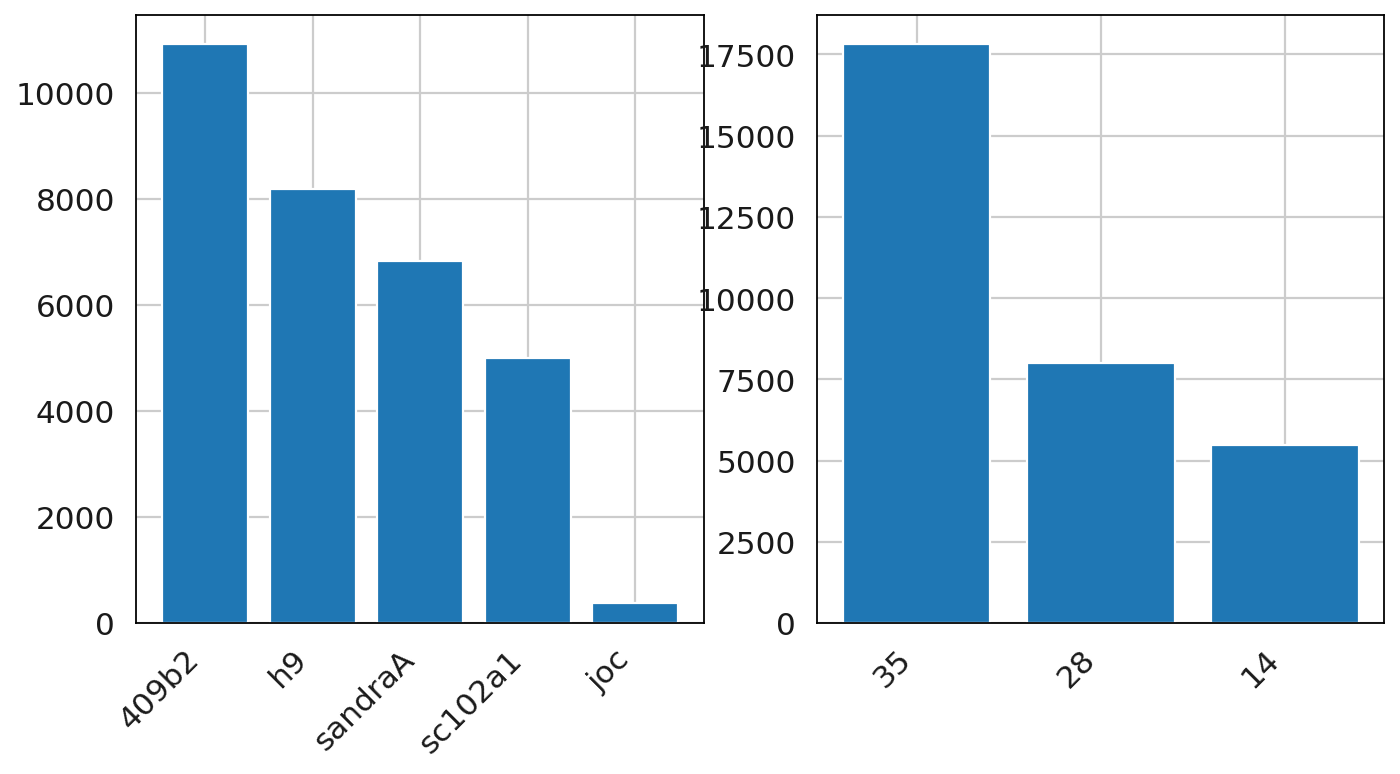

In [14]:
### Gestation week
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
x = adata.obs['line'].value_counts()
vs.plot_bar(axs[0], x)
x = adata.obs['timepoint_mapped'].value_counts()
vs.plot_bar(axs[1], x)
fig.savefig(config.PATHS.APPENDIX/'linetimebar')
fig.show()
us.log('', 'linetimebar')

In [15]:
# adata.obs['clusters'].value_counts().plot.barh()
# adata.obs['clusters'].value_counts()

# Top-expressed genes

/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


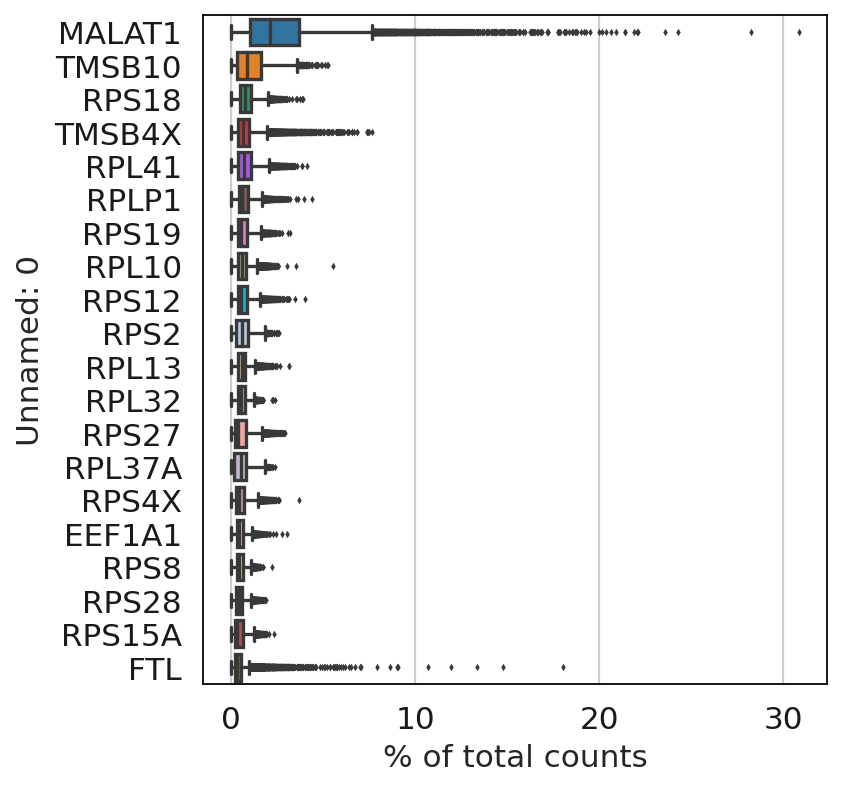

In [16]:
sc.pl.highest_expr_genes(adata, n_top=20)

# Quality Check

## Gene Filtering

In [17]:
# Filtering genes on minimum cells: 0.5%
state['MIN_CELLS'] = np.rint(
    (adata.n_obs * config.PROTO.QC.MIN_CELLS_PCT) / 100)
state['MIN_CELLS']

157.0

## Identify Mitocondrial and Ribosomal genes

In [18]:
#Find mito and ribo genes
mito_genes = adata.var_names.str.startswith('MT-')    
ribo_genes = adata.var_names.str.contains('^RPS|^RPL')

adata.var['mito'] = adata.var_names.str.startswith('MT-')    
adata.var['ribo']= adata.var_names.str.contains('^RPS|^RPL')

adata.var_names[ribo_genes]

Index(['RPL22', 'RPL11', 'RPS6KA1', 'RPS8', 'RPL5', 'RPS27', 'RPS6KC1', 'RPS7',
       'RPS27A', 'RPL31', 'RPL37A', 'RPL32', 'RPL15', 'RPSA', 'RPL14', 'RPL29',
       'RPL24', 'RPL22L1', 'RPL39L', 'RPL35A', 'RPL9', 'RPL34-AS1', 'RPL34',
       'RPS3A', 'RPL37', 'RPS23', 'RPS14', 'RPL26L1', 'RPS18', 'RPS10',
       'RPL10A', 'RPL7L1', 'RPS12', 'RPS6KA2', 'RPS6KA3', 'RPS4X', 'RPS6KA6',
       'RPL36A', 'RPL39', 'RPL10', 'RPS20', 'RPL7', 'RPL30', 'RPL8', 'RPS6',
       'RPL35', 'RPL12', 'RPL7A', 'RPLP2', 'RPL27A', 'RPS13', 'RPS6KA4',
       'RPS6KB2', 'RPS3', 'RPS25', 'RPS24', 'RPS26', 'RPL41', 'RPL6', 'RPLP0',
       'RPL21', 'RPL10L', 'RPS29', 'RPL36AL', 'RPS6KL1', 'RPS6KA5', 'RPS27L',
       'RPL4', 'RPLP1', 'RPS17', 'RPS2', 'RPS15A', 'RPL13', 'RPL26', 'RPL23A',
       'RPL23', 'RPL19', 'RPL27', 'RPS6KB1', 'RPL38', 'RPL17-C18orf32',
       'RPL17', 'RPS21', 'RPS15', 'RPL36', 'RPS28', 'RPL18A', 'RPS16', 'RPS19',
       'RPL18', 'RPL13A', 'RPS11', 'RPS9', 'RPL28', 'RPS5', 'RPL3', 'RPS19B

## Automated QC metrics

In [19]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=['mito','ribo'], inplace=True,
    log1p=False, percent_top=None)

adata.obs.head()

,timepoint,line,10X_date,clusters,tSNE_1,tSNE_2,cluster,timepoint_mapped,dataset,isHuman,isESC,n_genes_by_counts,total_counts,total_counts_mito,pct_counts_mito,total_counts_ribo,pct_counts_ribo
AAACCTGAGTACTTGC-9.w2_409b2_171212,w2,409b2,171212,C5,45.486102,-28.756658,C5,14,EMATB,True,False,2431,7029,170,2.418552,1754,24.953763
AAACCTGCACGGCCAT-9.w2_409b2_171212,w2,409b2,171212,C7,36.626131,6.664266,C7,14,EMATB,True,False,2570,7490,174,2.323097,1743,23.271028
AAACCTGCAGTATCTG-9.w2_409b2_171212,w2,409b2,171212,C5,36.483634,-26.967325,C5,14,EMATB,True,False,2437,6411,226,3.525191,1417,22.102636
AAACCTGGTTTAAGCC-9.w2_409b2_171212,w2,409b2,171212,C7,35.570214,34.445170,C7,14,EMATB,True,False,2749,8042,334,4.153196,1858,23.103706
AAACGGGCACGCCAGT-9.w2_409b2_171212,w2,409b2,171212,C5,36.968570,-28.070171,C5,14,EMATB,True,False,2128,5274,144,2.730375,1199,22.734168


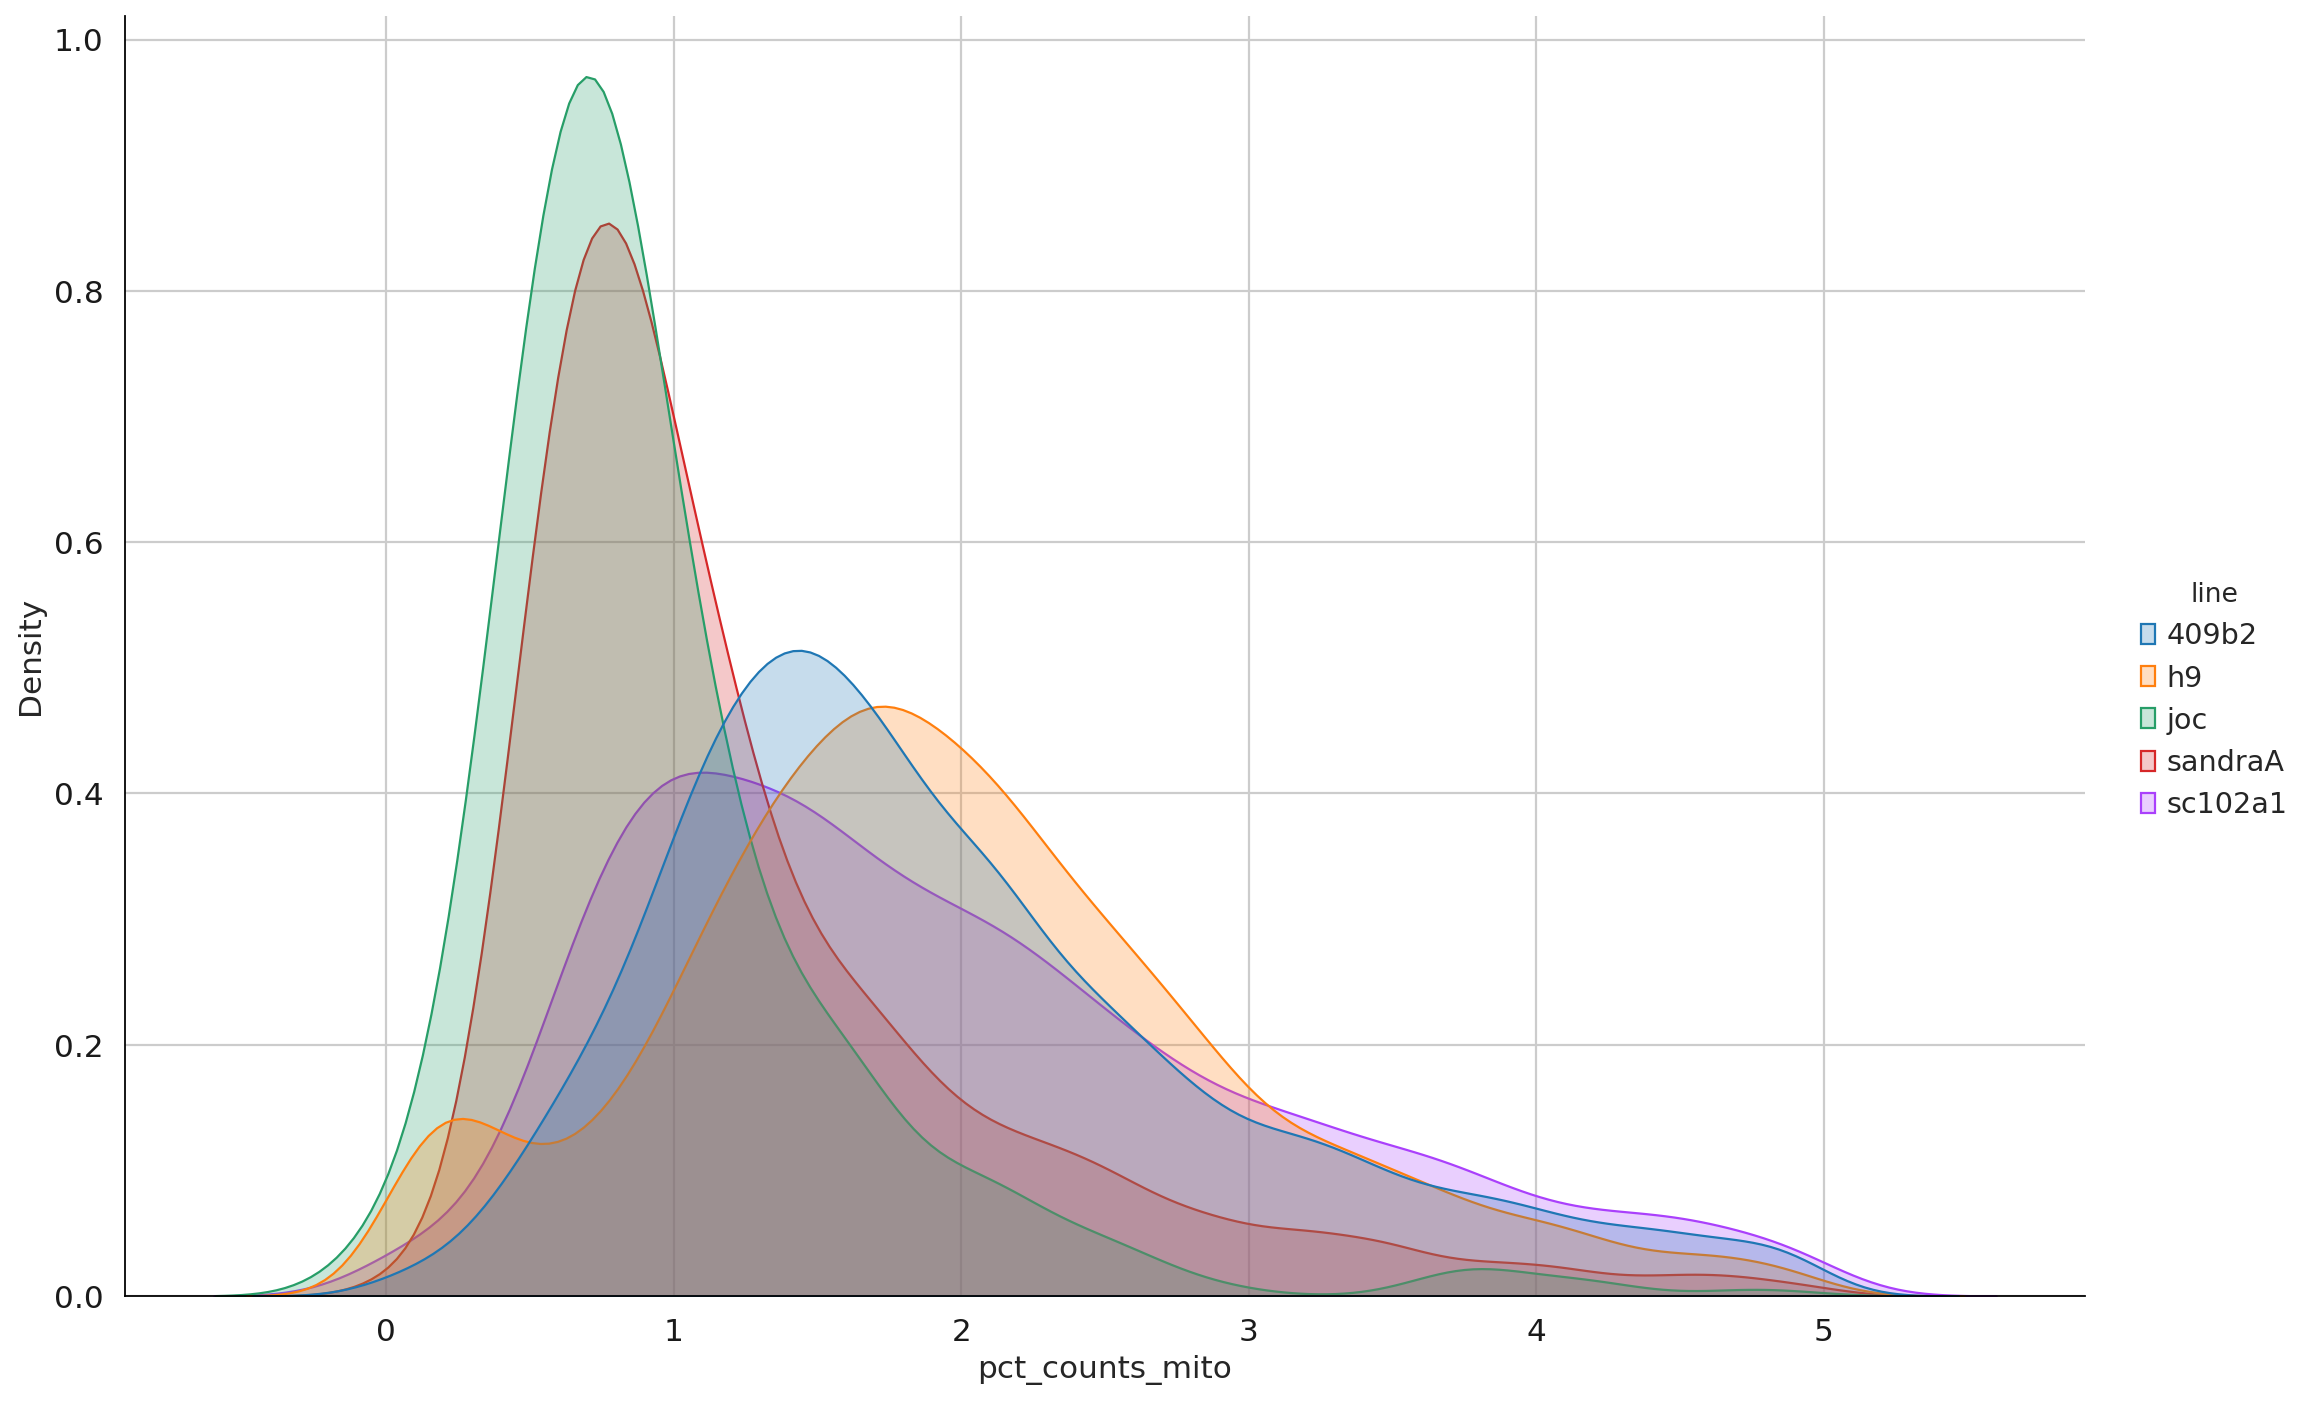

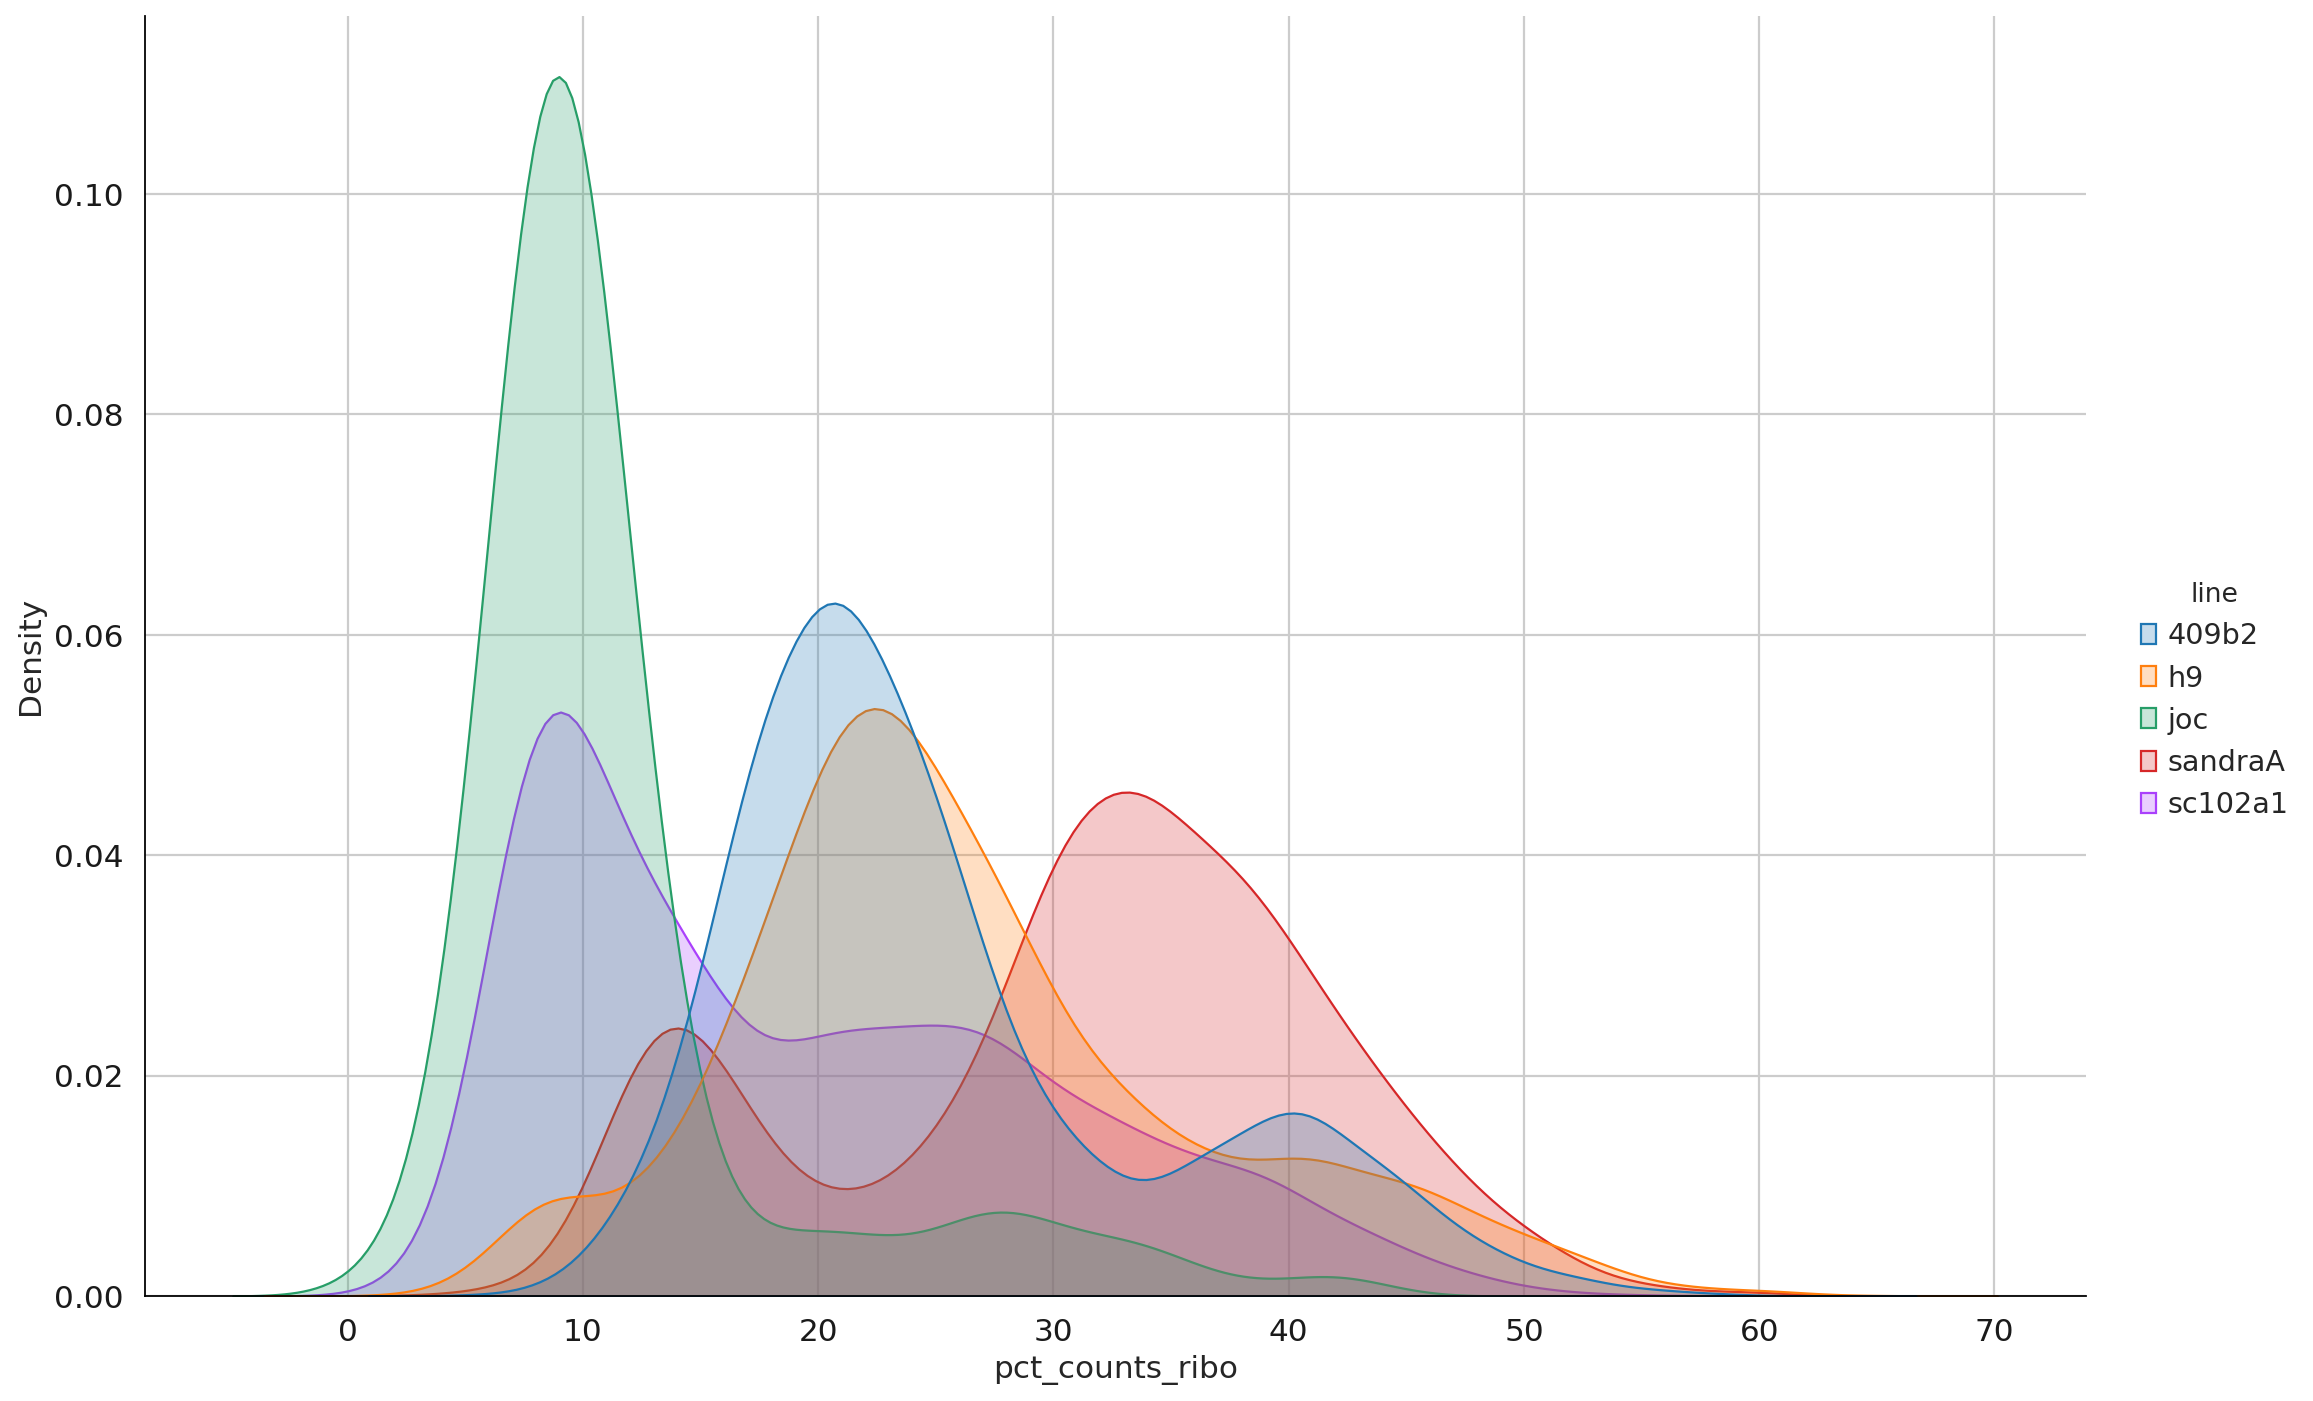

In [20]:
sns.displot(
    adata.obs, x="pct_counts_mito",
    hue="line", kind="kde", fill=True,
    # stat="density", 
    common_norm=False,
    height=9, aspect=1.5
)
sns.displot(
    adata.obs, x="pct_counts_ribo",
    hue="line", kind="kde", fill=True,
    # stat="density", 
    common_norm=False,
    height=9, aspect=1.5
)

In [20]:
# sc.pp.normalize_total(adata, target_sum=1e4, exclude_highly_expressed=True)
# sc.pp.log1p(adata)
# tsne = sc.tl.tsne(adata)

In [21]:
# sns.set(rc={'figure.figsize':(10,10)})
# sns.scatterplot(
#     data=adata.obs#[adata.obs.line == 'sandraA'],
#     x="tSNE_1", y="tSNE_2", hue="pct_counts_ribo",
#     hue_norm=(0, 60)
#     # legend=None
# )

## Inspect quality-related parameters

In [21]:
us.log('Mitochondrial genes')
us.log(np.quantile(adata.obs['pct_counts_mito'], np.arange(0, 1.1, 0.1))) 

Mitochondrial genes
[0.         0.65126337 0.90360118 1.1393734  1.37089141 1.60479866
 1.85956988 2.16804803 2.57431046 3.26557334 5.00406835]


In [22]:
us.log('Ribosomal Protein genes')
us.log(np.quantile(adata.obs['pct_counts_ribo'], np.arange(0, 1.1, 0.1)))

Ribosomal Protein genes
[ 1.4538846  12.359001   16.53162418 19.41563487 21.74537806 24.22391609
 27.1856061  31.00241309 35.7635653  41.14679735 65.13915547]


In [23]:
us.log('Total number of counts for each cell')
us.log(np.quantile(adata.obs['total_counts'], np.arange(0, 1.1, 0.1)))

Total number of counts for each cell
[  605.   2564.3  3391.   4192.9  5062.   6044.5  7147.   8704.  10945.4
 14842.7 57184. ]


In [24]:
us.log('Number of genes detected in each cell')
us.log(np.quantile(adata.obs['n_genes_by_counts'], np.arange(0, 1.1, 0.1)))

Number of genes detected in each cell
[ 503.  1153.3 1436.  1701.  1948.  2223.  2520.  2891.1 3356.  4087.7
 5971. ]


## Visualization
Violin plots: linear values

In [25]:
warnings.filterwarnings("ignore")

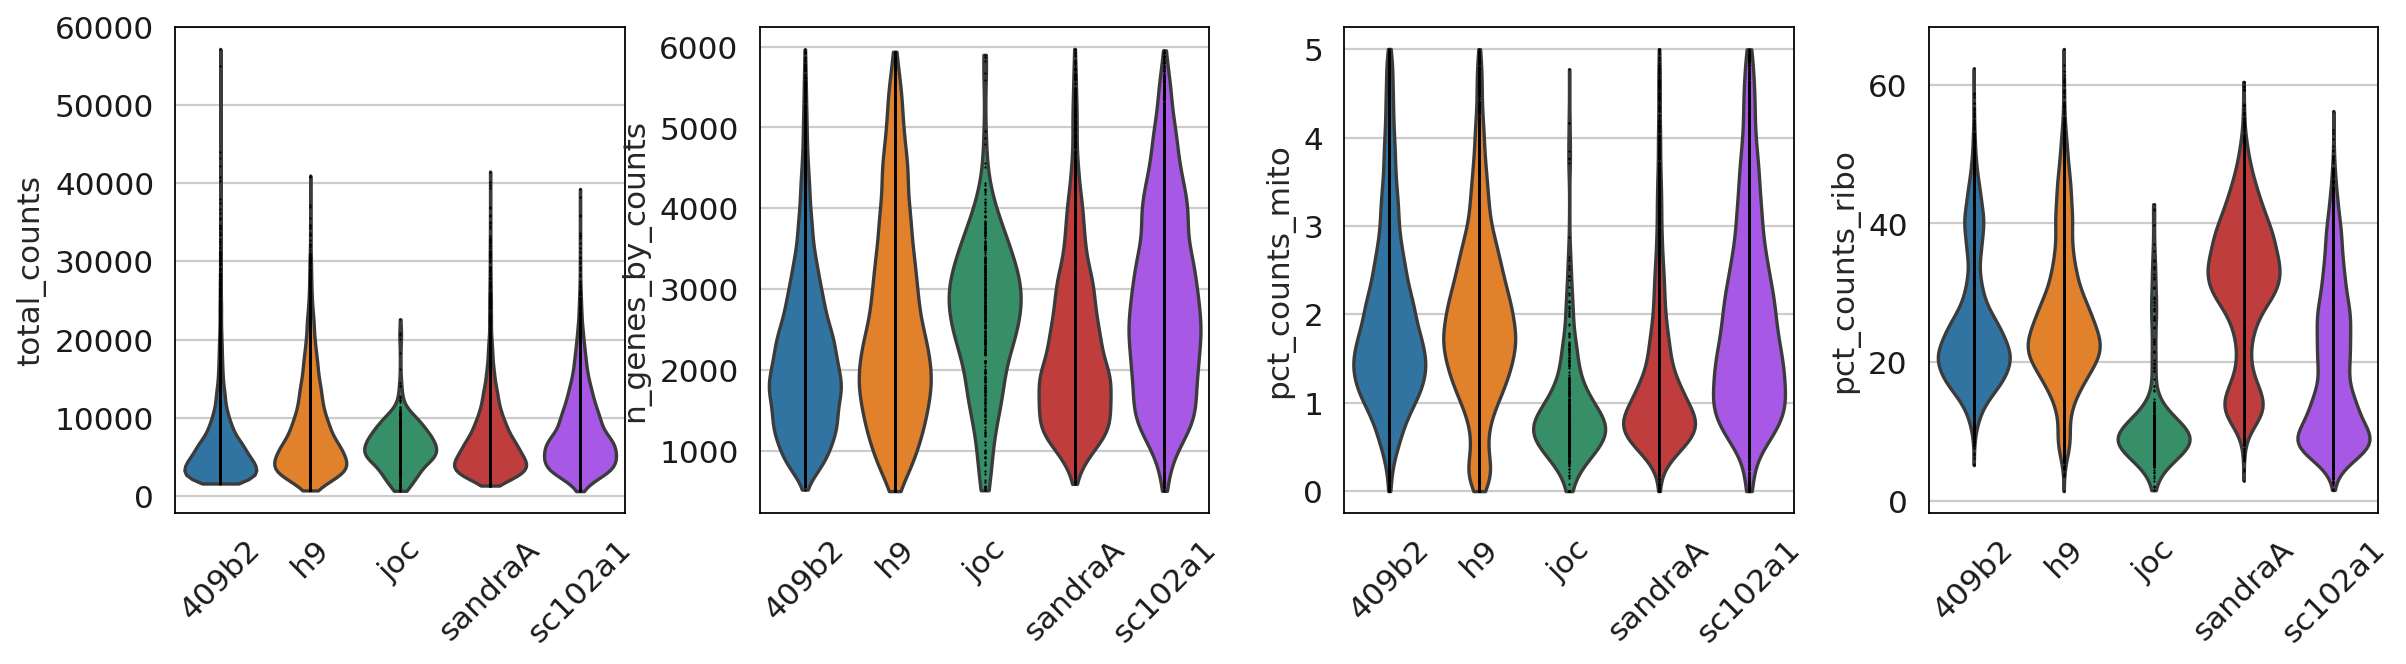

In [26]:
sc.pl.violin(adata, keys=['total_counts', 'n_genes_by_counts', 'pct_counts_mito', 'pct_counts_ribo'],
             jitter=False, multi_panel=True, groupby='line', rotation=45)

Violin plots: log values

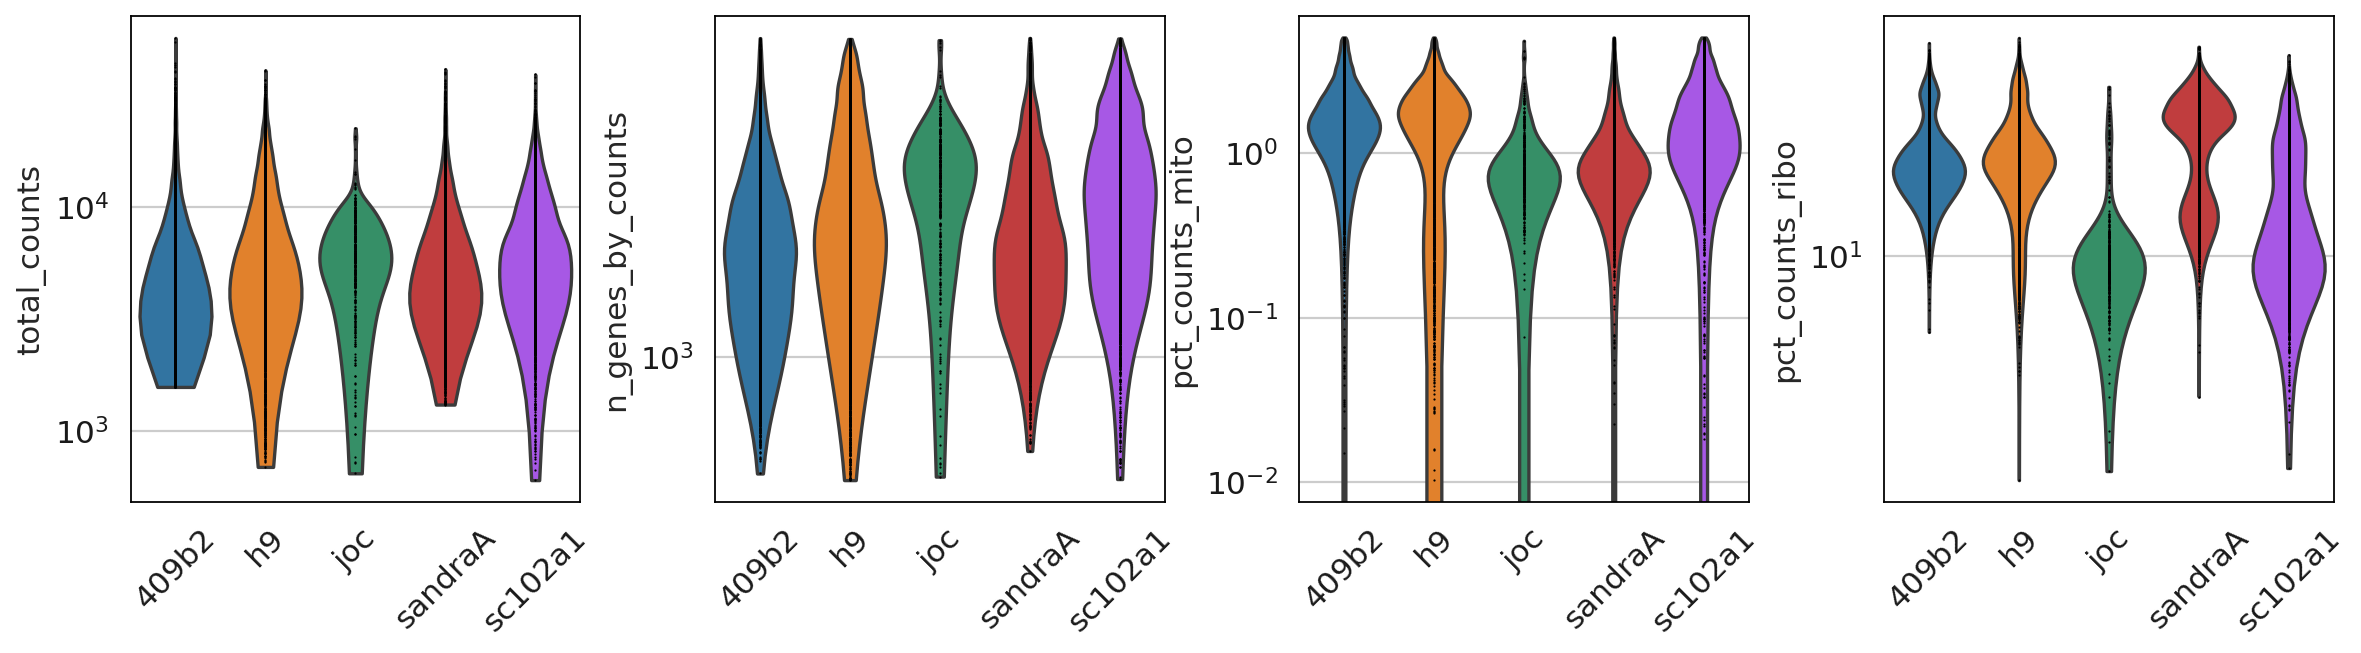

In [27]:
sc.pl.violin(adata, keys=['total_counts', 'n_genes_by_counts', 'pct_counts_mito', 'pct_counts_ribo'],
             jitter=False, multi_panel=True, log=True, groupby='line', rotation=45)

Density plots  

Single Plots

Thresholds applied


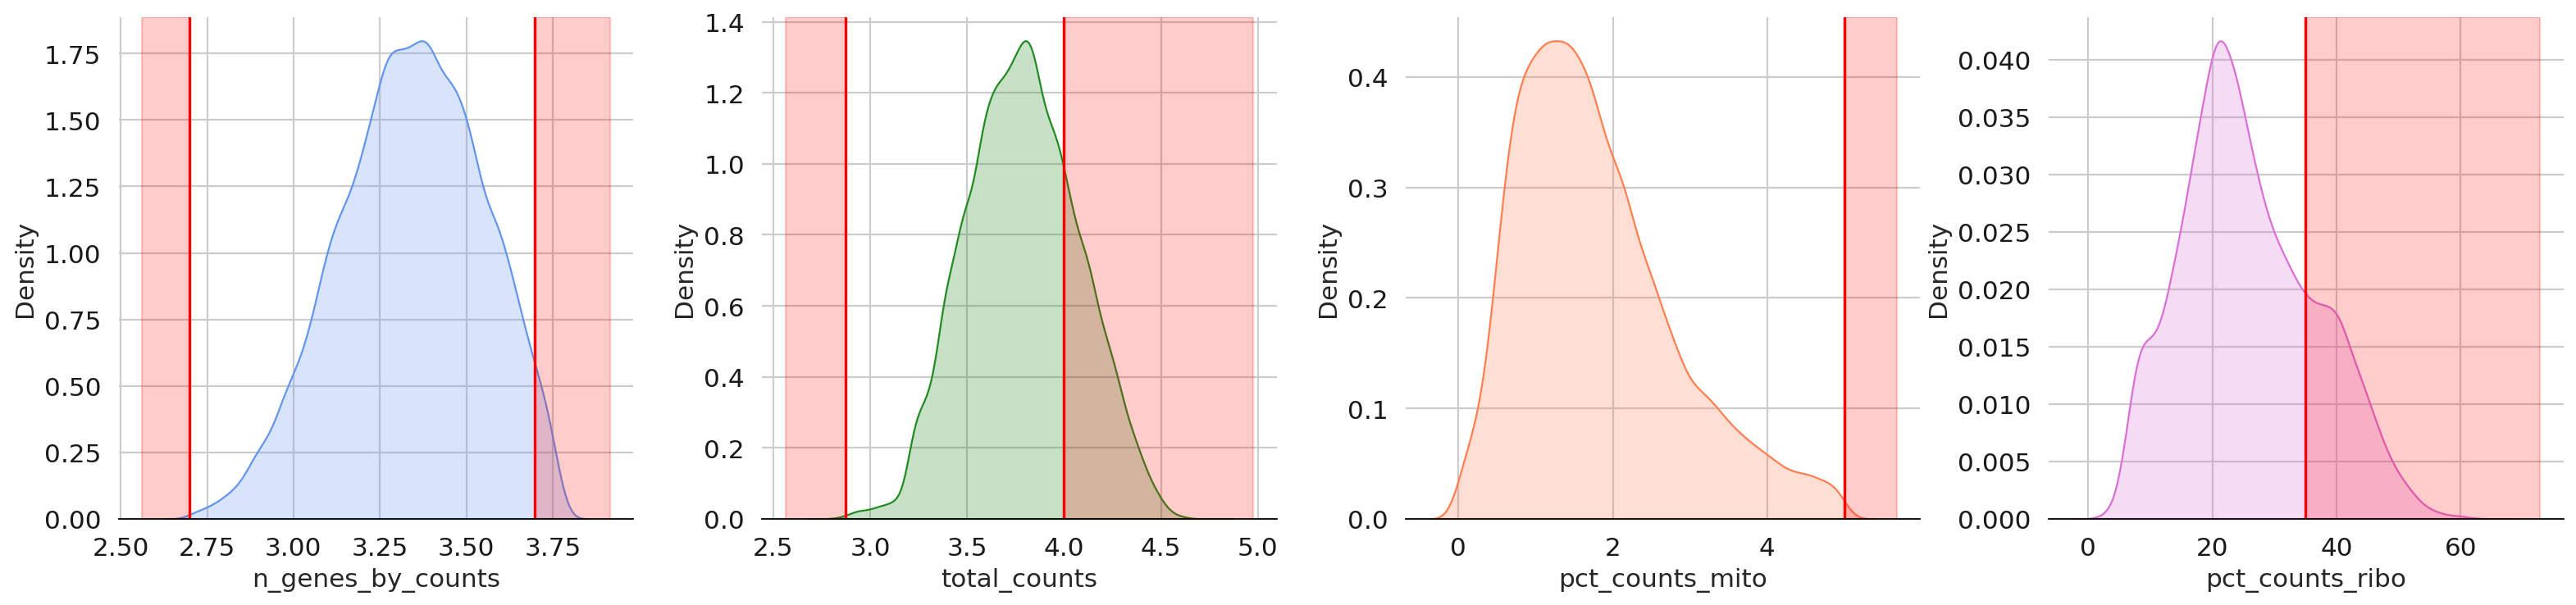

In [28]:
vs.densityQCs(adata)
plt.savefig(config.PATHS.APPENDIX/'QC_thresholds')
us.log('Thresholds applied', 'QC_thresholds')

Double Plots

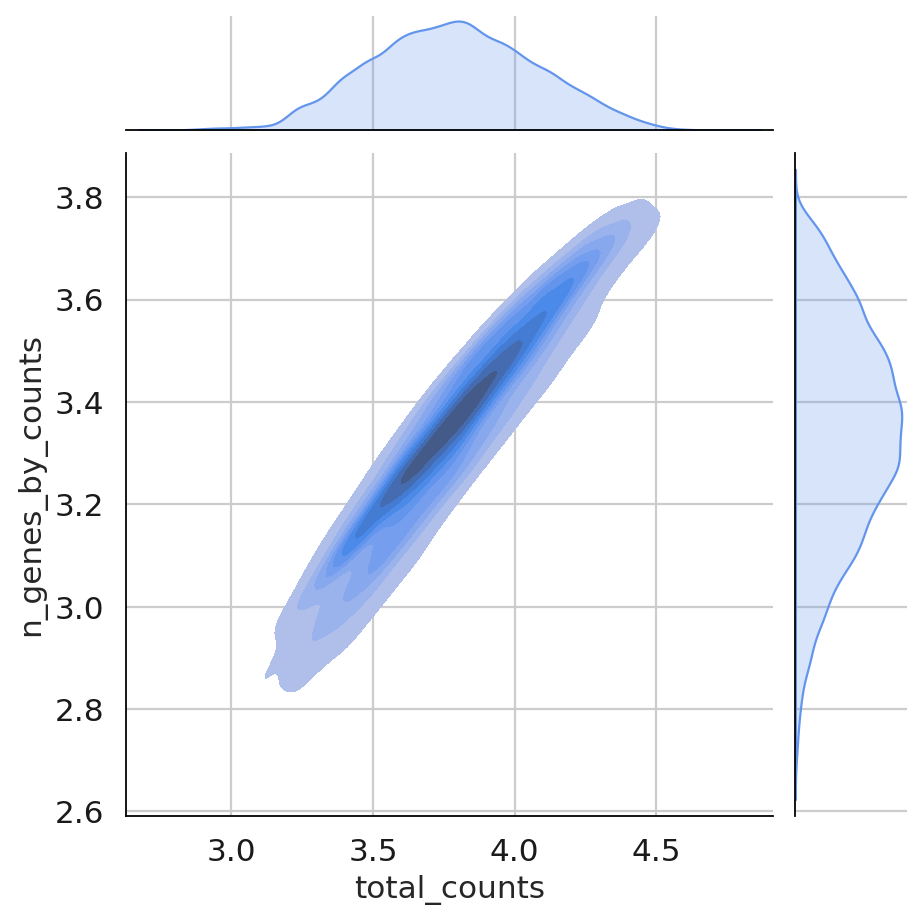

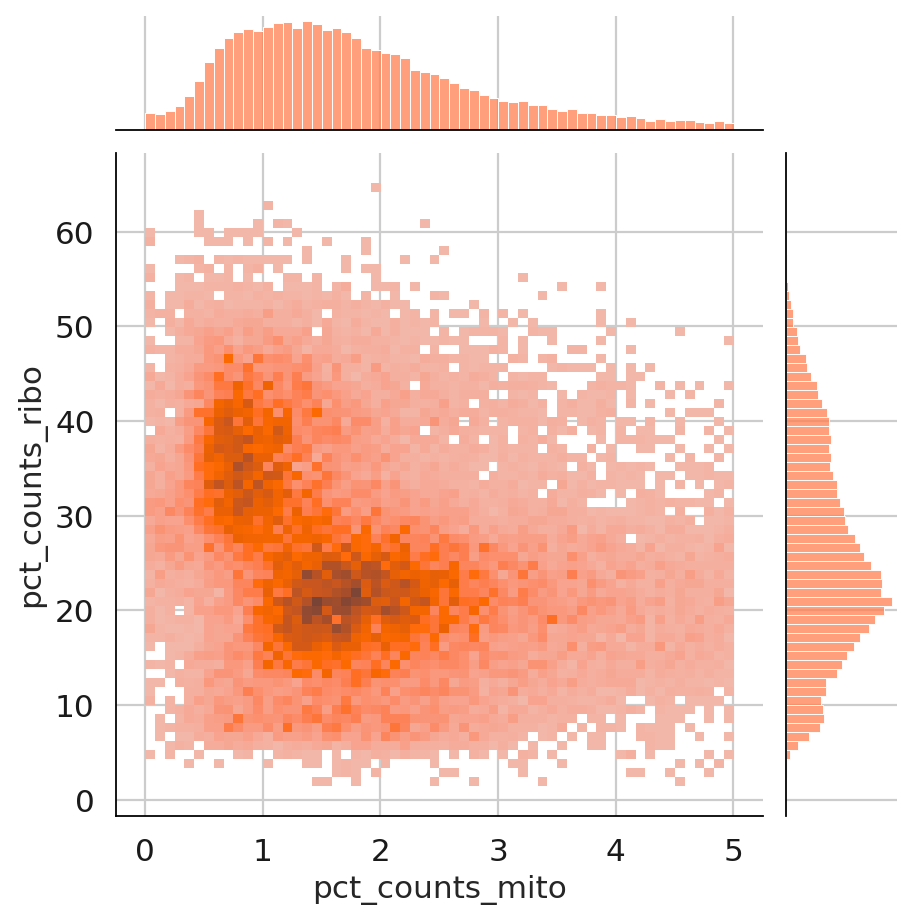

In [29]:
sns.jointplot(x=np.log10(adata.obs['total_counts']), 
              y=np.log10(adata.obs['n_genes_by_counts']), 
              kind="kde", color="cornflowerblue", fill=True)

sns.jointplot(x=adata.obs['pct_counts_mito'], 
              y=adata.obs['pct_counts_ribo'], 
              kind="hist", color="coral")

In [30]:
import scrublet as scr
scrub = scr.Scrublet(adata.X)
doublet_scores, predicted_doublets = scrub.scrub_doublets()
adata.obs['QC_doublets'] = doublet_scores

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.62
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 30.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.3%
Elapsed time: 48.9 seconds


In [31]:
# sns.scatterplot(
#     data=adata.obs[adata.obs.line == 'sandraA'], x="tSNE_1", y="tSNE_2", hue="QC_doublets",
#     hue_norm=(0, 1), legend=None
# )

In [32]:
adata = adata[~predicted_doublets]
us.log('{} predicted doublets removed'.format(len(predicted_doublets)))

31314 predicted doublets removed


# Filtering

In [33]:
message = '\n'.join([
    'The selected filtering parameters are: \n Minimum cells: {}'.format(
        state.MIN_CELLS), 
    ' Minimum counts: {}'.format(config.PROTO.QC.MIN_COUNTS), 
    ' Maximum counts: {}'.format(config.PROTO.QC.MAX_COUNTS),
    ' Minimum genes: {}'.format(config.PROTO.QC.MIN_GENES), 
    ' Maximum genes: {}'.format(config.PROTO.QC.MAX_GENES),
    ' Mitocondia: {}%'.format(config.PROTO.QC.MT_PERCENTAGE),
    ' Ribosomal: {}%'.format(config.PROTO.QC.RB_PERCENTAGE)])
us.log(message)

The selected filtering parameters are: 
 Minimum cells: 157.0
 Minimum counts: 750
 Maximum counts: 10000
 Minimum genes: 500
 Maximum genes: 5000
 Mitocondia: 5%
 Ribosomal: 35%


## Filtering Cells

In [34]:
# Detected Genes
sc.pp.filter_cells(adata, min_genes=config.PROTO.QC.MIN_GENES)
us.log('After filtering on min detected genes:number of cells: {}'.format(adata.n_obs))

# UMI Counts
sc.pp.filter_cells(adata, min_counts = config.PROTO.QC.MIN_COUNTS)
us.log('After filtering on min UMI counts:number of cells: {}'.format(adata.n_obs))

# Mitochondrial RNA

#adata.obs[adata.obs['percent_mito'] > 0.05]  
adata = adata[adata.obs['pct_counts_mito'] < config.PROTO.QC.MT_PERCENTAGE, :]
us.log('After filtering on mitochondrial RNA: number of cells: {}'.format(adata.n_obs))

# Ribosomal RNA

#adata = adata[adata.obs['percent_ribo'] < 0.35, :]
adata = adata[adata.obs['pct_counts_ribo'] < config.PROTO.QC.RB_PERCENTAGE, :]
us.log('After filtering on ribosomal protein RNA: number of cells: {}'.format(adata.n_obs))


After filtering on min detected genes:number of cells: 31284
filtered out 10 cells that have less than 750 counts
After filtering on min UMI counts:number of cells: 31274
After filtering on mitochondrial RNA: number of cells: 31269
After filtering on ribosomal protein RNA: number of cells: 24549


## Filtering genes

In [35]:
us.log('Before gene filtering: number of genes: {}'.format(adata.n_vars))
us.log('Before gene filtering: number of cells: {}'.format(adata.n_obs))

us.log(state.MIN_CELLS) # Filtering genes on minimum cells: 1%
sc.pp.filter_genes(adata, min_cells=state.MIN_CELLS)

us.log('After gene filtering: number of genes: {}'.format(adata.n_vars))
us.log('After filtering: number of cells: {}'.format(adata.n_obs))

Before gene filtering: number of genes: 17829
Before gene filtering: number of cells: 24549
157.0
filtered out 2496 genes that are detected in less than 157.0 cells
After gene filtering: number of genes: 15333
After filtering: number of cells: 24549


## Numbers after filtering

After applied filtering: number of cells: 24549
After applied filtering: number of genes: 15333


<Axes: xlabel='line'>

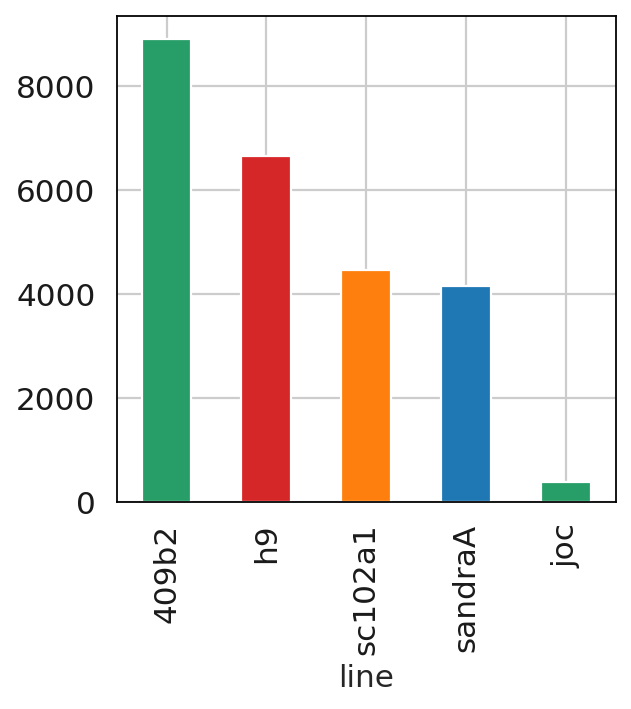

In [36]:
us.log('After applied filtering: number of cells: {}'.format(adata.n_obs))
us.log('After applied filtering: number of genes: {}'.format(adata.n_vars))

adata.obs['line'].value_counts().plot.bar(color=['#279e68', '#d62728', '#ff7f0e', '#1f77b4'])

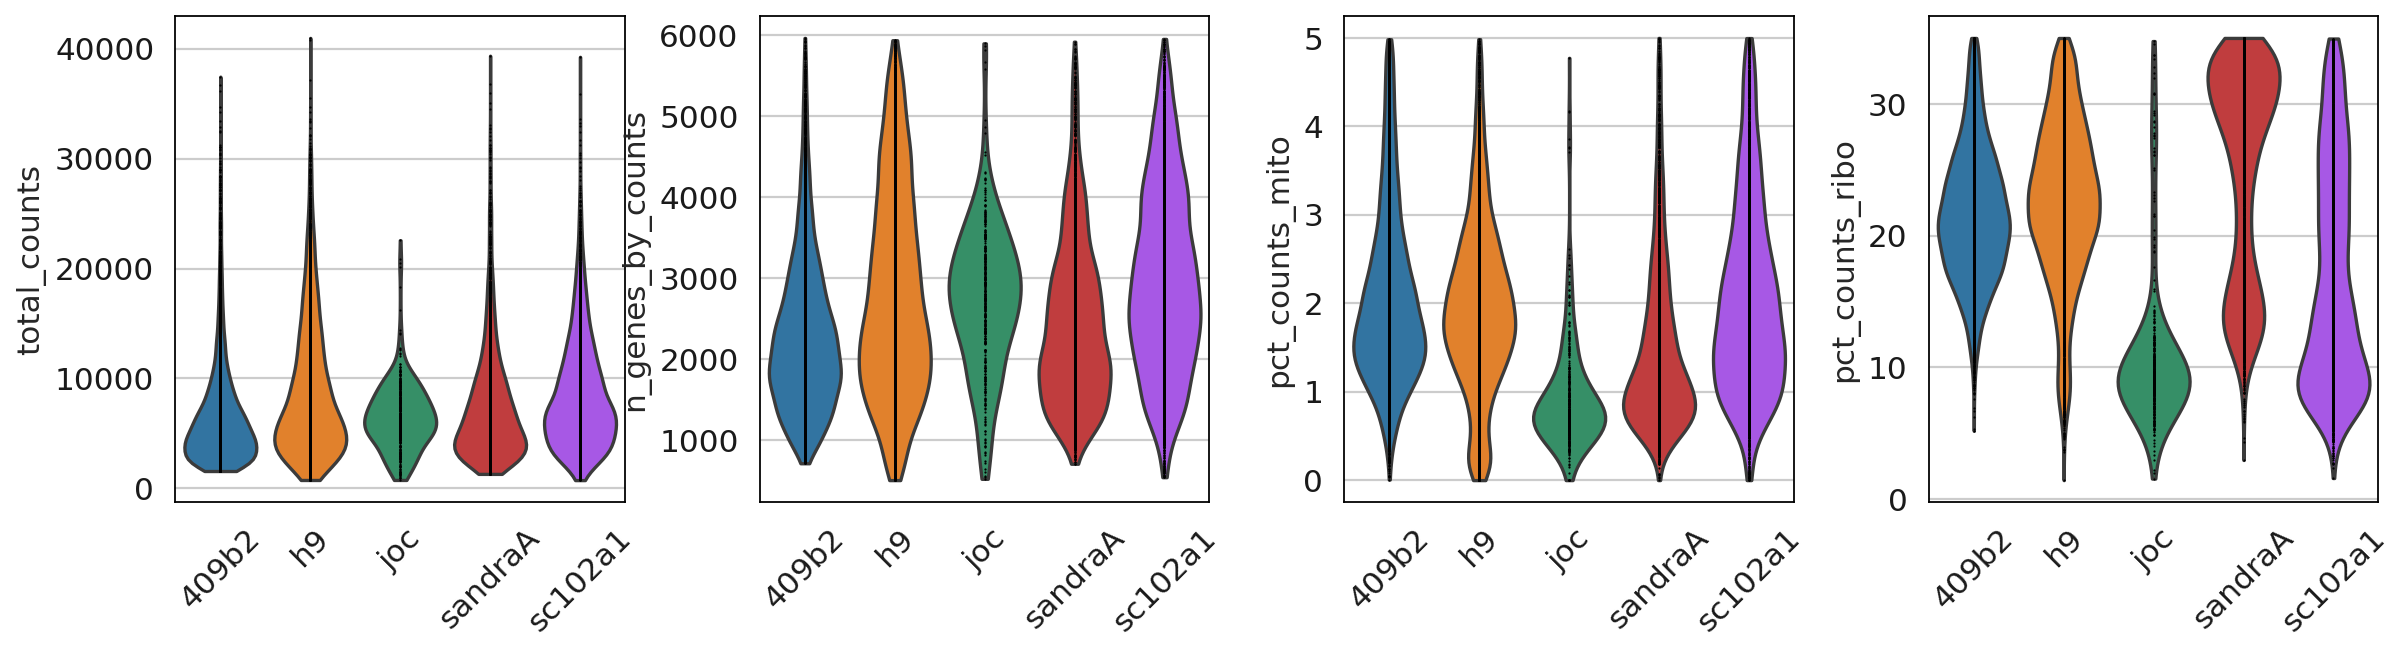

In [37]:
sc.pl.violin(
    adata, keys=['total_counts', 'n_genes_by_counts', 'pct_counts_mito', 'pct_counts_ribo'],
    groupby='line', jitter=False, multi_panel=True, rotation=45)


# Save

In [38]:
# Check that adata.X is stored as sparse if not convert
if (isspmatrix(adata.X) == False):
    adata.X = csr_matrix(adata.X)
    us.log("Converted adata.X to sparse")

In [39]:
adata.obs.cluster = adata.obs.cluster.astype(str)
adata.write(config.PATHS.LOGS/'QC.h5ad')
us.log(datetime.now() - time_start)

0:03:53.312907
